In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential, Model, Input
from keras.layers import Dense, Dropout, Activation, Flatten, Embedding
from keras.layers import  LSTM, MaxPooling1D, Concatenate
from keras.layers.wrappers import TimeDistributed
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from keras import metrics

In [2]:
import nltk, string, os
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

In [3]:
## read files

sample = pd.read_csv("sample_submission.csv")
test = pd.read_csv("test_file.csv")
train = pd.read_csv("train_file.csv")


In [4]:
sample.head()

,ID,MaterialType
0,31654,VIDEOCASS
1,31655,VIDEOCASS
2,31656,BOOK
3,31657,SOUNDDISC
4,31658,BOOK


In [5]:
## filter out columns which are not needed
cols = ['UsageClass','CheckoutType','CheckoutYear','CheckoutMonth']

train.drop([c for c in cols], axis =1, inplace = True)
train.head()


,ID,Checkouts,Title,Creator,Subjects,Publisher,PublicationYear,MaterialType
0,1,1,Tidal wave,NaN,"Tsunamis, Tsunamis Juvenile literature",NaN,NaN,BOOK
1,2,1,London holiday / Richard Peck.,"Peck, Richard, 1934-",NaN,"Viking,",1998.,BOOK
2,3,3,Cinco de Mayo : celebrating Hispanic pride / C...,"Gnojewski, Carol",Cinco de Mayo Mexican holiday History Juvenile...,"Enslow Publishers,",c2002.,BOOK
3,4,1,Annapolis,NaN,"War stories, Historical fiction, Domestic fict...",NaN,NaN,BOOK
4,5,1,As a man thinketh,NaN,Thought and thinking,NaN,NaN,BOOK


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31653 entries, 0 to 31652
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               31653 non-null  int64 
 1   Checkouts        31653 non-null  int64 
 2   Title            31653 non-null  object
 3   Creator          8516 non-null   object
 4   Subjects         29890 non-null  object
 5   Publisher        9737 non-null   object
 6   PublicationYear  9722 non-null   object
 7   MaterialType     31653 non-null  object
dtypes: int64(2), object(6)
memory usage: 1.9+ MB


In [7]:
train['MaterialType'].nunique()

8

In [8]:
train['Checkouts'].unique()

array([ 1,  3,  4,  2, 16,  5,  6,  7,  8, 18,  9, 21, 10, 34, 12, 14, 15,
       17, 13, 25, 11, 52, 20, 36, 84, 41, 27, 22, 45, 19, 39, 85, 28, 23,
       44, 30, 78, 24, 31, 38, 61, 56, 29, 42, 26, 40, 37, 33, 35, 77])

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31653 entries, 0 to 31652
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               31653 non-null  int64 
 1   Checkouts        31653 non-null  int64 
 2   Title            31653 non-null  object
 3   Creator          8516 non-null   object
 4   Subjects         29890 non-null  object
 5   Publisher        9737 non-null   object
 6   PublicationYear  9722 non-null   object
 7   MaterialType     31653 non-null  object
dtypes: int64(2), object(6)
memory usage: 1.9+ MB


/Users/himani/workspace/venv36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Distribution of label class in train dataset')

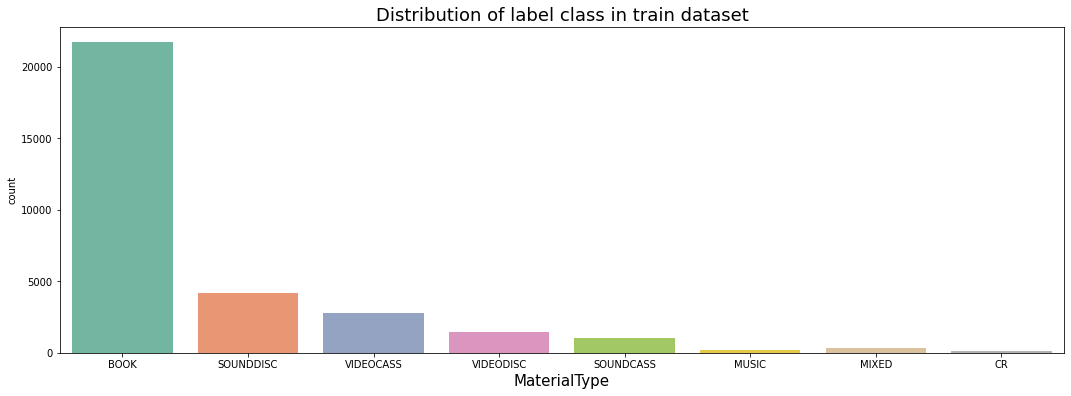

In [10]:
## distribution of class labels in train set

sns.set_color_codes()

fig, ax1 = plt.subplots(1,1, figsize = (18,6))

sns.countplot('MaterialType', data = train,palette="Set2", ax = ax1)
ax1.set_xlabel("MaterialType", size = 15)
plt.title("Distribution of label class in train dataset", size = 18)

In [11]:
# # download stopwords and wordnet

# nltk.download("stopwords")
# nltk.download("wordnet")
# nltk.download('omw-1.4')

In [12]:
# remove stopwords, punctuations, numerics,lemmatizer (to get stem of a word e.g. stem for 'caring' is 'care')
# remove numbers, but not words that contain numbers, and words with only one character

stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

# clean raw corpus

def clean(doc):
    num_free = " ".join([token for token in doc.split() if not token.isnumeric()])
    stop_free = " ".join([i for i in num_free.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

In [13]:
train.columns

Index(['ID', 'Checkouts', 'Title', 'Creator', 'Subjects', 'Publisher',
       'PublicationYear', 'MaterialType'],
      dtype='object')

In [14]:
train['Creator']

0                         NaN
1        Peck, Richard, 1934-
2            Gnojewski, Carol
3                         NaN
4                         NaN
                 ...         
31648                     NaN
31649                     NaN
31650                     NaN
31651        Willingham, Bill
31652                     NaN
Name: Creator, Length: 31653, dtype: object

In [18]:
## replace null values with empty strings

train['Creator'].fillna("",inplace= True)
train['Subjects'].fillna("",inplace= True)
train['Publisher'].fillna("",inplace=True)
train['PublicationYear'] = train['PublicationYear'].str.extract('(\d+)')
train['PublicationYear'].fillna('0',inplace= True)
train['PublicationYear'] = train['PublicationYear'].astype(int)
train['Publisher'].shape

(31653,)

In [19]:
train['PublicationYear'].max()

2013

In [20]:
### clean columns

train['Title'] = train['Title'].apply(lambda x: clean(x))
train['Creator'] = train['Creator'].apply(lambda x: clean(x))
train['Subjects'] = train['Subjects'].apply(lambda x: clean(x))
train['Publisher'] = train['Publisher'].apply(lambda x: clean(x)if pd.notnull(x) else x)


In [21]:
## encoding class labels

## process labels- label encoding

le = LabelEncoder()
labels_int = le.fit_transform(train['MaterialType'].values)
labels = to_categorical(labels_int)

### prepare tokenizer for all nlp inputs

t_title, t_creator, t_subjects, t_publisher = Tokenizer(), Tokenizer(), Tokenizer(), Tokenizer()
t_title.fit_on_texts(train['Title'].values)
t_creator.fit_on_texts(train['Creator'].values)
t_subjects.fit_on_texts(train['Subjects'].values)
t_publisher.fit_on_texts(train['Publisher'].values)

vocab_size_title = len(t_title.word_index) + 1
vocab_size_creator = len(t_creator.word_index) + 1
vocab_size_subjects = len(t_subjects.word_index) +1
vocab_size_publisher = len(t_publisher.word_index) +1

print("vocab size title:",vocab_size_title)
print("vocab size creator:",vocab_size_creator)
print("vocab size subjects:", vocab_size_subjects)
print("vocab size publisher:", vocab_size_publisher)

vocab size title: 29698
vocab size creator: 7193
vocab size subjects: 12008
vocab size publisher: 3054


## Model - pre trained Glove 50D word embeddings

In [22]:
glove_path = "/Users/himani/workspace"

# load the whole embedding into memory
embeddings_index = dict()
f = open(os.path.join(glove_path,'glove.42B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded {0} word vectors.'.format(len(embeddings_index)))

Loaded 1917494 word vectors.


In [23]:
embedding_matrix_title = np.zeros((vocab_size_title, 300))
for word, i in t_title.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_title[i] = embedding_vector

print(embedding_matrix_title.shape)

embedding_matrix_creator = np.zeros((vocab_size_creator, 300))
for word, i in t_creator.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_creator[i] = embedding_vector

print(embedding_matrix_creator.shape)

embedding_matrix_subjects = np.zeros((vocab_size_subjects, 300))
for word, i in t_subjects.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_subjects[i] = embedding_vector

print(embedding_matrix_subjects.shape)


embedding_matrix_publisher = np.zeros((vocab_size_publisher, 300))
for word, i in t_publisher.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_publisher[i] = embedding_vector

print(embedding_matrix_publisher.shape)

(29698, 300)
(7193, 300)
(12008, 300)
(3054, 300)


In [26]:
maxlen_title = 75
maxlen_creator = 15
maxlen_subject = 75
maxlen_publisher = 20

# integer encode the documents
enc_title_docs = t_title.texts_to_sequences(train['Title'].values)
enc_creator_docs = t_creator.texts_to_sequences(train['Creator'].values)
enc_subjects_docs = t_subjects.texts_to_sequences(train['Subjects'].values)
enc_publisher_docs = t_publisher.texts_to_sequences(train['Publisher'].values)

# # pad documents to a max variable length of words

padded_title_docs = pad_sequences(enc_title_docs, maxlen=maxlen_title, padding='post')
padded_creator_docs = pad_sequences(enc_creator_docs, maxlen=maxlen_creator, padding='post')
padded_subjects_docs = pad_sequences(enc_subjects_docs, maxlen=maxlen_subject, padding='post')
padded_publisher_docs = pad_sequences(enc_publisher_docs,maxlen=maxlen_publisher, padding='post')
print("padded_docs:",len(padded_title_docs),len(padded_creator_docs),
      len(padded_subjects_docs), len(padded_publisher_docs))

padded_docs: 31653 31653 31653 31653


### creating model

In [29]:
### NLP Inputs

hidden_size1, hidden_size2 = 128, 64
output_size = 8

title = Input(shape=(maxlen_title,))
creator = Input(shape=(maxlen_creator,))
subject = Input(shape = (maxlen_subject,))
publisher = Input(shape=(maxlen_publisher,))
# publicationyear = Input(shape=(1))


embedded_title = Embedding(vocab_size_title, 300,weights=[embedding_matrix_title],
                           input_length=maxlen_title,trainable=False)(title)
encoded_title = LSTM(300, return_sequences=True)(embedded_title)

encoded_creator = Embedding(vocab_size_creator, 300,weights=[embedding_matrix_creator],
                            input_length=maxlen_creator,trainable=False)(creator)
embedded_subject = Embedding(vocab_size_subjects,300,weights=[embedding_matrix_subjects],
                             input_length=maxlen_subject,trainable=False)(subject)
encoded_subject = LSTM(300,return_sequences=True)(embedded_subject)

encoded_publisher = Embedding(vocab_size_publisher,300,weights=[embedding_matrix_publisher],
                              input_length=maxlen_publisher,trainable=False)(publisher)

# Rest of the nlp NN, which knows how to put everything together to get an output.
merged = Concatenate(axis =1)([encoded_title, encoded_creator,encoded_subject,encoded_publisher])
rest_of_nn = Dense(hidden_size1, activation='tanh')(merged)
rest_of_nn = Flatten()(rest_of_nn)
rest_of_nn = Dropout(0.2)(rest_of_nn)
rest_of_nn = Dense(hidden_size2,activation='relu')(rest_of_nn)
rest_of_nn = Dropout(0.2)(rest_of_nn)
rest_of_nn = Dense(output_size, activation='softmax')(rest_of_nn)


# Create the model, assuming some sort of classification problem.
model = Model(inputs=[title, creator,subject,publisher], outputs=rest_of_nn)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 75)]         0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 75)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 75, 300)      8909400     input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 15)]         0                                            
______________________________________________________________________________________________

In [30]:
model.fit([padded_title_docs,padded_creator_docs,
           padded_subjects_docs,padded_publisher_docs],labels, batch_size=8, epochs=5)

Epoch 1/5
2590/3957 [==================>...........] - ETA: 7:48 - loss: 0.4881 - acc: 0.8592

KeyboardInterrupt: 

In [33]:
!python --version

Python 3.6.5
